# MNIST

### MNIST 데이터 받기

In [1]:
import os
import sys
from six.moves import urllib
import gzip
import pickle
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt


SOURCE_URL = 'http://www.iro.umontreal.ca/~lisa/deep/data/mnist/mnist.pkl.gz'
FILENAME = SOURCE_URL.split('/')[-1]
DATA_DIR = './datasets'

def maybe_download(data_dir):
    filepath = os.path.join(data_dir, FILENAME)
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)
    if not os.path.isfile(filepath):
        def _progress(count, block_size, total_size):
            sys.stdout.write('\r>> Downloading {} {:.1f} %'.format(
                FILENAME, float(count * block_size) / float(total_size) * 100.0))
            sys.stdout.flush()
        filepath, _ = urllib.request.urlretrieve(SOURCE_URL, filepath, _progress)
        print()
        statinfo = os.stat(filepath)
        print('Successfully donloaded', FILENAME, statinfo.st_size, 'bytes.')

def load(data_dir, subset='train'):
    maybe_download(data_dir)
    filepath = os.path.join(data_dir, FILENAME)
    
    f = gzip.open(filepath, 'rb')
    u = pickle._Unpickler(f)
    u.encoding = 'latin1'
    train_set, valid_set, test_set = u.load()
    f.close()
    
    if subset == 'train':
        trainx, trainy = train_set
        trainx = trainx.astype(np.float32).reshape(trainx.shape[0], 28, 28)
        trainy = trainy.astype(np.uint8)
        return trainx, trainy
    elif subset == 'test':
        testx, testy = test_set
        testx = testx.astype(np.float32).reshape(testx.shape[0], 28, 28)
        testy = testy.astype(np.uint8)
        return testx, testy
    elif subset== 'valid':
        validx, validy = valid_set
        validx = validx.astype(np.float32).reshape(validx.shape[0], 28, 28)
        validy = validy.astype(np.uint8)
        return validx, validy
    else:
        raise NotImplementedError('subset should be train or valid or test')

# Load data
train_data, train_label = load(DATA_DIR, 'train')
valid_data, valid_label = load(DATA_DIR, 'valid')
test_data, test_label = load(DATA_DIR, 'test')

# concatenate train and valid data as train data
train_data = np.concatenate((train_data, valid_data))
train_label = np.concatenate((train_label, valid_label))

### MNIST 데이터 확인 하기

In [2]:
# size of MNIST
print(train_data.shape)
print(train_label.shape)
print(test_data.shape)
print(test_label.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


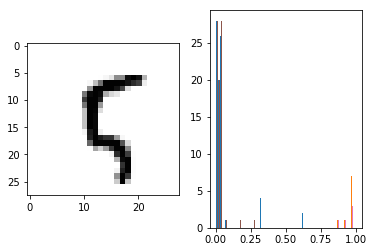

In [3]:
# show data
_, (ax1, ax2) = plt.subplots(1, 2)
sample_data = train_data[100]
ax1.imshow(sample_data, cmap=plt.cm.Greys);
ax2.hist(sample_data, bins=20, range=[0, 1]);

In [4]:
import tensorflow as tf
from tensorflow.nn import rnn_cell

In [5]:
learning_rate = 1e-3
num_epochs = 2
batch_size = 100
num_display = 100

def RNN(X):
    X = tf.unstack(X, num=28, axis=1) #쪼개짐
    lstm = rnn_cell.LSTMCell(128, forget_bias=0.9) #lstmcell 생성 #forget_gate(스위치 1:켜짐~0:꺼짐)의 크기
    outs = tf.nn.static_rnn(lstm, X, dtype=tf.float32)
    #print(outs)
    #print(len(outs))
    outs=outs[0][-1]
    return outs
    
def get_model(X, by):
    #X = tf.expand_dims(X, axis=3) # (None, 28, 28, 1)
    
    outs = RNN(X)
    #print(outs)
    
    #outs = tf.reshape(outs, (-1, outs.shape[1]*outs.shape[2]*outs.shape[3]))
    outs = tf.layers.dense(outs, 256)
    outs = tf.nn.relu(outs)
    #outs=tf.layers.dropout(outs, rate=0.5) #dropout/ 0.5=>매순간마다 50%씩 버리겠다
    outs = tf.layers.dense(outs, 10)
    one_hot = tf.one_hot(by, 10)
    
    loss = tf.nn.softmax_cross_entropy_with_logits_v2(logits=outs, 
                                                      labels=one_hot)
    loss = tf.reduce_mean(loss)
    opt = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)
    
    preds = tf.cast(tf.argmax(tf.nn.softmax(outs), axis=1), tf.int32)
    acc = tf.reduce_mean(tf.cast(tf.equal(by, preds), tf.float32))
#     saver = tf.train.Saver(tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'second')
#                           +tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'third')
#                           +tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'dense')) #미리 학습해놓은 파라미터를 쓰고 싶을 때 # 그래프에서 전역변수 모여있는 것들 다 불러옴 
    init = tf.global_variables_initializer()
    return {
        'loss': loss,
        'opt': opt,
        'preds': preds,
        'acc': acc,
        'init': init
    }

In [6]:
X = tf.placeholder(tf.float32, shape=(None, 28, 28))
by = tf.placeholder(tf.int32)

model = get_model(X, by)

In [7]:
#model = get_model(X, by)
with tf.Session() as sess:
    sess.run(model['init'])
    for ind_epoch in range(0, num_epochs):
        print('Current iteration {}'.format(ind_epoch + 1))
        
        for ind_ in range(0, int(60000 / batch_size)):
            batch_X = train_data[ind_*batch_size:(ind_+1)*batch_size]
            batch_by = train_label[ind_*batch_size:(ind_+1)*batch_size]
            _, cur_loss, cur_acc = sess.run(
                [model['opt'], model['loss'], model['acc']],
                feed_dict={X: batch_X, by: batch_by})
            if ind_ % num_display == 0:
                print('loss {0:.4f} acc {1:.4f}'.format(cur_loss, cur_acc))
    cur_acc_all = 0.0
    cur_loss_all = 0.0
    for ind_ in range(0, 10):
        cur_loss, cur_acc = sess.run(
                    [model['loss'], model['acc']],
                    feed_dict={X: test_data[ind_*1000:(ind_+1)*1000], 
                               by: test_label[ind_*1000:(ind_+1)*1000]})
        cur_loss_all += cur_loss
        cur_acc_all += cur_acc
    print('TEST: loss {0:.4f} acc {1:.4f}'.format(cur_loss_all / 10.0, 
                                                  cur_acc_all / 10.0))

Current iteration 1
loss 2.2978 acc 0.1000
loss 0.8638 acc 0.6700
loss 0.6157 acc 0.8200
loss 0.3664 acc 0.8700
loss 0.2904 acc 0.8800
loss 0.2946 acc 0.9000
Current iteration 2
loss 0.1612 acc 0.9500
loss 0.2965 acc 0.9200
loss 0.2602 acc 0.9200
loss 0.2086 acc 0.9200
loss 0.1048 acc 0.9700
loss 0.0744 acc 0.9600
TEST: loss 0.1207 acc 0.9631


In [8]:
# model = get_model(X, by, False) #처음 선언하는 거니깐 False
# with tf.Session() as sess:
#     sess.run(model['init'])
#     for ind_epoch in range(0, num_epochs):
#         print('Current iteration {}'.format(ind_epoch + 1))
        
#         for ind_ in range(0, int(60000 / batch_size)):
#             batch_X = train_data[ind_*batch_size:(ind_+1)*batch_size]
#             batch_by = train_label[ind_*batch_size:(ind_+1)*batch_size]
#             _, cur_loss, cur_acc = sess.run(
#                 [model['opt'], model['loss'], model['acc']],
#                 feed_dict={X: batch_X, by: batch_by})
#             if ind_ % num_display == 0:
#                 print('loss {0:.4f} acc {1:.4f}'.format(cur_loss, cur_acc))
#     model['saver'].save(sess,'./ours.ckpt')

In [9]:
# model = get_model(X, by, True)
# with tf.Session() as sess:
#     sess.run(model['init']) #first는 저장을 하지 않았기 때문에 걔를 초기화
#     model['saver'].restore(sess,'./ours.ckpt')
#     cur_acc_all = 0.0
#     cur_loss_all = 0.0
#     for ind_ in range(0, 10):
#         cur_loss, cur_acc = sess.run(
#                     [model['loss'], model['acc']],
#                     feed_dict={X: test_data[ind_*1000:(ind_+1)*1000], 
#                                by: test_label[ind_*1000:(ind_+1)*1000]})
#         cur_loss_all += cur_loss
#         cur_acc_all += cur_acc
#     print('TEST: loss {0:.4f} acc {1:.4f}'.format(cur_loss_all / 10.0, 
#                                                   cur_acc_all / 10.0))

# ##first는 학습을 하지 않아서 acc가 좀 낮게 나옴
# ##기존에 있던 파라미터를 잘 골라서 저장하고 저장해놓은거를 불러와서 road하고 사용